The purpose of this investigation is to demonstrate the effects of $\color{blue}{\alpha_1}$ and $\color{red}{\alpha_2}$ on the potential connectivity of a landscape with a fixed covariate surface.

Potential connectivity is given by sum of use probabilities:

$$C^P(i) = \sum_{j} Pr(g[i,j])$$ 
$$ Pr(g[i,j]) = e^{-\color{blue}{\alpha_1} d_{ecol}(i,j)^2}
= \left( e^{d_{ecol}(i,j)^2} \right)^{-\color{blue}{\alpha_1}}
= \left( e^{d_{ecol}(i,j)^2} \right)^{-\color{blue}{\frac{1}{2\sigma^2}}}$$

So, **$\alpha_1$ modulates the rate at which ecological distance causes use probabilities to decay**; larger $\alpha_1$ values lead to a more rapid decay. This is like an animal species that is less willing to move through large ecological distances.

Ecological distance is given by:

$$d_{ecol}(i,j) = min_{\mathcal{L}} \sum_{p=1}^{m+1} cost(v_p,v_{p+1}) d_{euc}(v_p, v_{p+1}) 
= min_{\mathcal{L}} \sum_{p=1}^{m+1} e^{\alpha_2 \frac{z(v_p) + z(v_{p+1})}{2}} d_{euc}(v_p, v_{p+1}) 
= min_{\mathcal{L}} \sum_{p=1}^{m+1} \left(e^{\frac{z(v_p) + z(v_{p+1})}{2}}\right)^{\color{red}{\alpha_2}} d_{euc}(v_p, v_{p+1})$$

Therefore, **$\alpha_2$ modulates the extent to which the landscape covariate increases the ecological distance**. In our current experiments, high covariate values represent high resistance to movement and poor habitat, so larger $\alpha_2$ values lead to a stronger dependence of ecological distance on covariate values. This is like an animal species whose movement is highly affected by the covariate surface. $\alpha_2=0$ reduces to the case of using Euclidean distance.

Both higher $\color{blue}{\alpha_1}$ and $\color{red}{\alpha_2}$ work to reduce the use probabilities $Pr(g[i,j])$. Hence, an increase in $\color{red}{\alpha_2}$ can be counteracted by a decrease in $\color{blue}{\alpha_1}$, which is precisely the mechanism used to maintain home ranges at a constant size under the two $\color{red}{\alpha_2}$ settings. For example, when an animal species's movement is highly affected by (sensitive to) the covariate surface (high alpha2), precicted ecological distances will be higher than Euclidean, but to keep home range size constant we will choose low alpha1 to make the species less sensitive to ecological distances overall. 

How does this affect the connectivity over the overall landscape?

I proceed by using a single covariate surface and computing the use probabilities under the two different $(\alpha_1, \alpha_2)$ scenarios. The target home range size is 64 pixels. *****I computed $\alpha_1$ value for each resistance setting using the corresponding effective sigma values taken from Dana's manuscript:

$$\alpha_2 = 0.25 \implies \sigma_{effective} = 0.1677509 \implies \alpha_1 = 17.76807123$$
$$\alpha_2 = 1.75 \implies \sigma_{effective} = 0.3749552 \implies \alpha_1 = 3.55640524856$$

Given the covariate surface, I compute the $d_{ecol}(i,j)$ (least-cost shortest paths) under each setting. (Note, I do not know what order of magnitude the $d_{euc}(v_p, v_{p+1})$ distances actually are; I set the distance between horizontally/vertically adjacent pixels to be $0.1$ units, so the distance between diagonally adjacent pixels is $\sqrt{0.02}$ units; this gives me use probability values that are comparable to the values in the potmat matrices I am working with.) *** double check 4 vs 8 neighbors


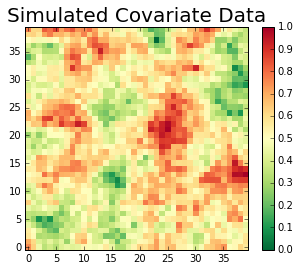

In [1]:
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import rasterio
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

covariatedatafilename = "../Desktop/hropt/Data/simcov_a2025_S100_cov.tif"
with rasterio.open(covariatedatafilename) as src:
    r = src.read()
    covdata = r.squeeze()
#     covdata[0][39] = 5
    plt.figure(figsize=(5, 4))
    plt.imshow(covdata, interpolation='nearest', cmap=cm.RdYlGn_r, alpha=1.0, origin="lower") # interpolation can be nearest, bilinear, bicubic
    plt.colorbar()
    plt.grid(False)
    plt.title('Simulated Covariate Data', fontsize=20)
    plt.show()

Parameter settings: a1 = 17.76807123, a2 = 0.25
Finished computing all pairs shortest paths.
Parameter settings: a1 = 3.55640524856, a2 = 1.75
Finished computing all pairs shortest paths.


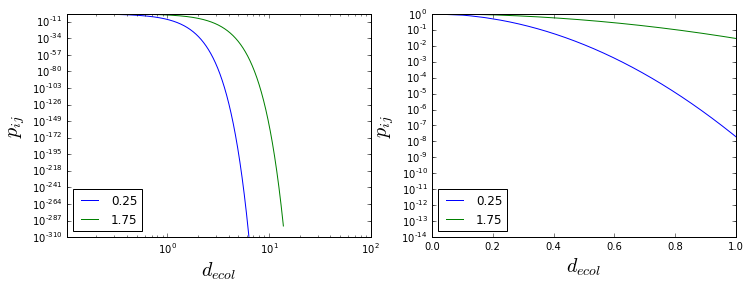

In [8]:
alpha2 = [0.25, 1.75]
effsig = [0.1677509, 0.3749552]
# effsig = [0.5, 0.5]
useprobs = dict()
pc = dict()
plt.figure(figsize=(12, 4))
for a2idx in range(len(alpha2)):
    # get the correct parameters for this alpha2 setting
    es = effsig[a2idx]
    a0 = 1
    a1 = 1/(2*es*es)
    a2 = alpha2[a2idx]
    print("Parameter settings: a1 = %s, a2 = %s" %(a1, a2))
    
    # create the graph
    nrow = 40
    ncol = 40
    nodes = [_ for _ in range(nrow*ncol)]
    pos = [] # positions for visualizing using nx.draw()
    graph = nx.Graph()
    for n in nodes:
        graph.add_node(n)
        col = n/ncol
        row = n%ncol
        pos.append((row, col))
    for r in range(nrow-1):
        for c in range(ncol):
            # vertical edges across rows
            graph.add_edge(r*ncol + c, (r+1)*ncol + c, weight=0.1*math.exp(a2*(covdata[r][c]+covdata[r+1][c])/2))
        for c in range(ncol-1):
            # diagonal edges across rows (row and col increasing)
            graph.add_edge(r*ncol + c, (r+1)*ncol + c + 1, weight=math.sqrt(0.02)*math.exp(a2*(covdata[r][c]+covdata[r+1][c+1])/2))
    for c in range(ncol-1):
        for r in range(nrow):
            # horizontal edges across columns
            graph.add_edge(r*ncol + c, r*ncol + c + 1, weight=0.1*math.exp(a2*(covdata[r][c]+covdata[r][c+1])/2))
        for r in range(1,nrow):
            # diagonal edges across rows (row decreasing col increasing)
            graph.add_edge(r*ncol + c, (r-1)*ncol + c + 1, weight=math.sqrt(0.02)*math.exp(a2*(covdata[r][c]+covdata[r-1][c+1])/2))
    graph = graph.to_undirected()
    
    # compute all pair shortest paths
    apsp = nx.all_pairs_dijkstra_path_length(graph)
    print("Finished computing all pairs shortest paths.")
    
    # collect path lengths
    decol = []
    useprobs[a2] = np.zeros((nrow*ncol, nrow*ncol))
    pc[a2] = np.zeros(nrow*ncol)
    for j in nodes:
        jsum = 0
        for i in nodes:
            d = apsp[i][j]
            decol.append(d)
            useprobs[a2][i][j] = a0*(math.exp(-(d*d)))**a1
            jsum = jsum + useprobs[a2][i][j]
        pc[a2][j] = jsum
#         if isum>0:
#             print(isum)
    pc[a2] = pc[a2].reshape(40,40)
            
    
    # turn into x axis "scale" by eliminating duplicate values and sorting
    decolscale = sorted(set(decol))
    
    # compute pij's
    pij = []
    for d in decolscale:
        pij.append(a0*(math.exp(-(d*d)))**a1)
    plt.subplot(1,2,1)
    plt.loglog(decolscale, pij)
    plt.subplot(1,2,2)
    plt.semilogy(decolscale, pij) # we will zoom in to this plot

plt.subplot(1,2,1)
plt.legend(alpha2, loc="lower left")
plt.xlabel(r'$d_{ecol}$', fontsize=20)
plt.ylabel(r'$p_{ij}$', fontsize=20)
axes = plt.gca()
axes.set_xlim([0,100])

plt.subplot(1,2,2)
plt.legend(alpha2, loc="lower left")
plt.xlabel(r'$d_{ecol}$', fontsize=20)
plt.ylabel(r'$p_{ij}$', fontsize=20)
axes = plt.gca()
axes.set_xlim([0,1])
axes.set_ylim([10e-15,1])
plt.show()

The right graph is a zoomed-in version of the left graph. Both show that for any value for ecological distance, the use probability is higher for the $\alpha_2=1.75$ case than for the $\alpha_2=0.25$ case. To verify that my computations for $d_{ecol}$ and $p_{ij}$ were correct, I compared the potential connectivity surface from my recomputations with that provided with the data.

Max pc, recomputed: 14.6295624668
Max pc, data: 15.0203015382


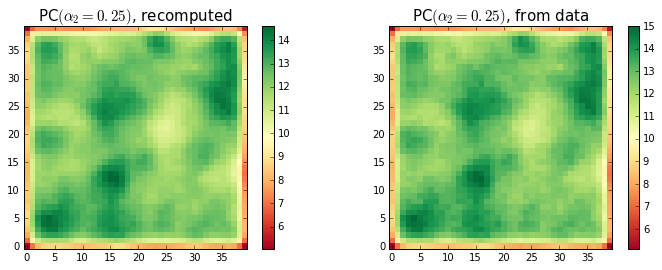

In [3]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.imshow(pc[0.25], interpolation='nearest', cmap=cm.RdYlGn, alpha=1.0, origin="lower") # interpolation can be nearest, bilinear, bicubic
print("Max pc, recomputed: %s"%pc[0.25].max())
plt.colorbar()
plt.grid(False)
plt.title(r'PC$(\alpha_2=0.25)$, recomputed', fontsize=15)
# plt.show()
datasetfilename = "../Desktop/hropt/Data/simcov_a2025_S100_pc.tif"
with rasterio.open(datasetfilename) as src:
    r = src.read()
    data = r.squeeze()
    print("Max pc, data: %s"%data.max())
    data = np.transpose(data)
#     plt.figure(figsize=(5, 4))
    plt.subplot(1,2,2)
    plt.imshow(data, interpolation='nearest', cmap=cm.RdYlGn, alpha=1.0, origin="lower") # interpolation can be nearest, bilinear, bicubic
    plt.colorbar()
    plt.grid(False)
    plt.title(r'PC$(\alpha_2=0.25)$, from data', fontsize=15)
    plt.show()

Max pc, recomputed: 30.0952856827
Max pc, data: 32.6987691947


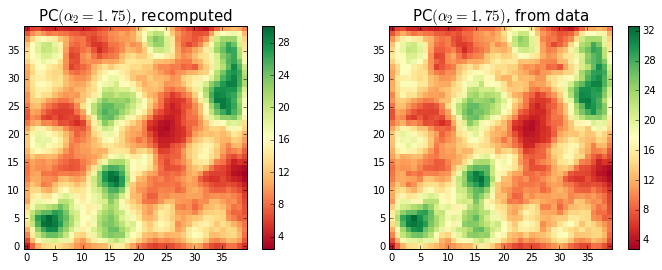

In [4]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.imshow(pc[1.75], interpolation='nearest', cmap=cm.RdYlGn, alpha=1.0, origin="lower") # interpolation can be nearest, bilinear, bicubic
print("Max pc, recomputed: %s"%pc[1.75].max())
plt.colorbar()
plt.grid(False)
plt.title(r'PC$(\alpha_2=1.75)$, recomputed', fontsize=15)
# plt.show()
datasetfilename = "../Desktop/hropt/Data/simcov_a2175_S100_pc.tif"
with rasterio.open(datasetfilename) as src:
    r = src.read()
    data = r.squeeze()
    print("Max pc, data: %s"%data.max())
    data = np.transpose(data)
#     plt.figure(figsize=(5, 4))
    plt.subplot(1,2,2)
    plt.imshow(data, interpolation='nearest', cmap=cm.RdYlGn, alpha=1.0, origin="lower") # interpolation can be nearest, bilinear, bicubic
    plt.colorbar()
    plt.grid(False)
    plt.title(r'PC$(\alpha_2=1.75)$, from data', fontsize=15)
    plt.show()

And comparing the distributions of pixel-wise potential connectivities $C^P(i)$:

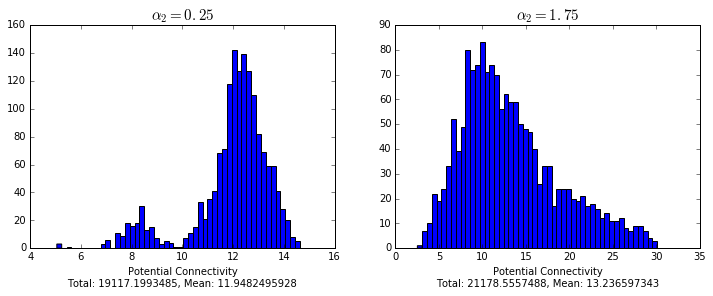

In [5]:
pcvals025 = pc[0.25].reshape(1600,1)
pcvals175 = pc[1.75].reshape(1600,1)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
n, bins, patches = plt.hist(pcvals025,50)
# plt.ylabel('Potential Connectivity')
plt.xlabel('Potential Connectivity\nTotal: %s, Mean: %s'%(sum(pcvals025)[0], np.mean(pcvals025)))
plt.title(r'$\alpha_2=0.25$',fontsize=15)
plt.subplot(1,2,2)
n, bins, patches = plt.hist(pcvals175,50)
plt.title(r'$\alpha_2=1.75$', fontsize=15)
plt.xlabel('Potential Connectivity\nTotal: %s, Mean: %s'%(sum(pcvals175)[0], np.mean(pcvals175)))
plt.show()

The recomputed potential connectivity surfaces look qualitatively similar to those from the dataset, and differences can probably be attributed to the distances I used between adjacent pixels. The higher potential connectivity in the $\alpha_2=1.75$ case suggests that the willingness of the animals to travel greater ecological distances ($\color{blue}{\alpha_1}$) overpowers the increased perceived ecological distance caused by the covariate surface ($\color{red}{\alpha_2}$). In a real case study, there is only one value of $\alpha_2$ for the species and only one corresponding $\alpha_1$ value. However, if we want to compare landscape reserve design for animals whose movement is either strongly or weakly linked to the covariate surface, i.e. treating $\alpha_2$ as the (only) resistance parameter, this "willingness" caused by $\alpha_1$ may be a confounding factor.

Since we are interested in maintaining home range size constant, I examined the distributions of home range sizes (using the 99% home range size to try to get the mean home range size of ~64 pixels reported in the manuscript). However, **I got home range sizes of ~52 and ~56 pixels for $\alpha_2=0.25$ and $\alpha_2=1.75$ respectively, with widely differing distributions**.

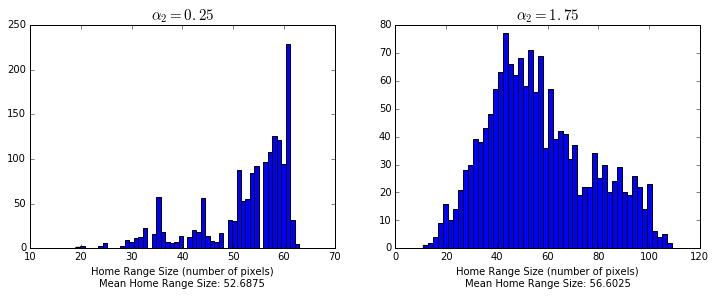

In [6]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
hrsize = []
potmat = useprobs[0.25]
low = potmat < 0.01
potmat[low] = 0
for p in range(1600):
    hrsize.append((potmat[p,]!=0).sum())
n, bins, patches = plt.hist(hrsize,50)
# plt.ylabel("Home Range Size (number of pixels)")
plt.xlabel("Home Range Size (number of pixels)\nMean Home Range Size: %s"%np.mean(hrsize))
plt.title(r'$\alpha_2=0.25$',fontsize=15)


plt.subplot(1,2,2)
hrsize = []
potmat = useprobs[1.75]
low = potmat < 0.01
potmat[low] = 0
for p in range(1600):
    hrsize.append((potmat[p,]!=0).sum())
n, bins, patches = plt.hist(hrsize,50)
plt.xlabel("Home Range Size (number of pixels)\nMean Home Range Size: %s"%np.mean(hrsize))
plt.title(r'$\alpha_2=1.75$',fontsize=15)
plt.show()

Next, we inspect the 95% home range for a particular activity center. Two are shown below. It appears that for activity centers in areas of low covariate (low resistance) such as pixels 125 and 110, the $\alpha_2 = 1.75$ case has a larger home range with higher use probabilities than for the low-resistance case. This can be seen by the darker green coloring (higher use probabilities) in $\alpha_2=1.75$ of the 8 pixels immediately surrounding activity center 110, and the higher potential connectivity of the pixel. More pixels must be conserved in order to protect these home ranges, but the subsequent connectivity reward is higher. Conversely, in areas with high covariate (high resistance) such as around pixels 475 and 825, the $\alpha_2 = 1.75$ case has a smaller home range with lower total potential connectivity. Fewer pixels are needed to conserve these home ranges, but the connectivity gain is smaller.

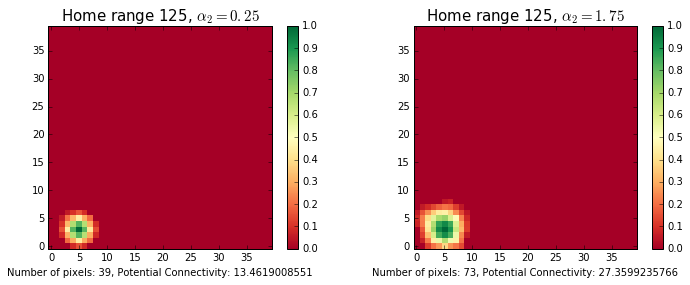

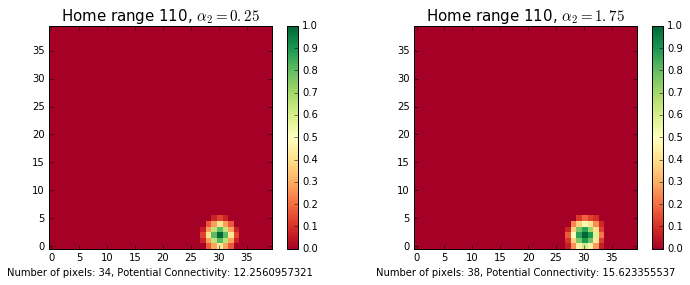

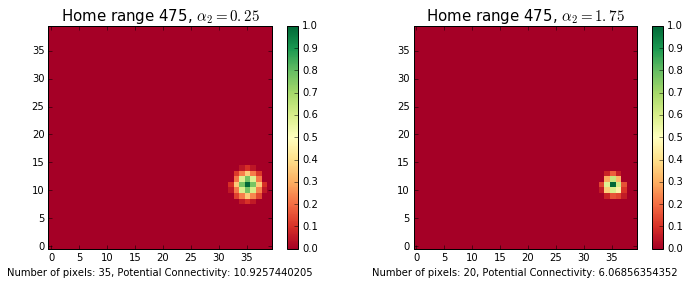

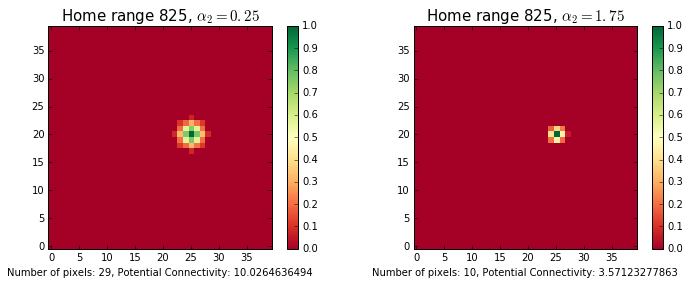

In [7]:
# HR 125 #
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
potmat = useprobs[0.25]
low = potmat < 0.05
potmat[low] = 0
hr125 = potmat[125,].reshape(40,40)
plt.imshow(hr125, interpolation='nearest', cmap=cm.RdYlGn, alpha=1.0, vmin=0, vmax=1, origin="lower")
plt.colorbar()
plt.title(r'Home range 125, $\alpha_2=0.25$', fontsize=15)
plt.xlabel('Number of pixels: %s, Potential Connectivity: %s'%((potmat[125,]!=0).sum(), potmat[125,].sum()))

plt.subplot(1,2,2)
potmat = useprobs[1.75]
low = potmat < 0.05
potmat[low] = 0
hr125 = potmat[125,].reshape(40,40)
plt.imshow(hr125, interpolation='nearest', cmap=cm.RdYlGn, alpha=1.0, vmin=0, vmax=1, origin="lower")
plt.colorbar()
plt.title(r'Home range 125, $\alpha_2=1.75$', fontsize=15)
plt.xlabel('Number of pixels: %s, Potential Connectivity: %s'%((potmat[125,]!=0).sum(), potmat[125,].sum()))
plt.show()

# HR 110 #
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
# with open(datasetfilename) as potmatdata:
# potmat = np.loadtxt(potmatdata)
potmat = useprobs[0.25]
low = potmat < 0.05
potmat[low] = 0
hr110 = potmat[110,].reshape(40,40)
plt.imshow(hr110, interpolation='nearest', cmap=cm.RdYlGn, alpha=1.0, vmin=0, vmax=1, origin="lower")
plt.colorbar()
plt.title(r'Home range 110, $\alpha_2=0.25$', fontsize=15)
plt.xlabel('Number of pixels: %s, Potential Connectivity: %s'%((potmat[110,]!=0).sum(), potmat[110,].sum()))

plt.subplot(1,2,2)
# with open(datasetfilename) as potmatdata:
# potmat = np.loadtxt(potmatdata)
potmat = useprobs[1.75]
low = potmat < 0.05
potmat[low] = 0
hr110 = potmat[110,].reshape(40,40)
plt.imshow(hr110, interpolation='nearest', cmap=cm.RdYlGn, alpha=1.0, vmin=0, vmax=1, origin="lower")
plt.colorbar()
plt.title(r'Home range 110, $\alpha_2=1.75$', fontsize=15)
plt.xlabel('Number of pixels: %s, Potential Connectivity: %s'%((potmat[110,]!=0).sum(), potmat[110,].sum()))
plt.show()

# HR 475 #
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
# with open(datasetfilename) as potmatdata:
# potmat = np.loadtxt(potmatdata)
potmat = useprobs[0.25]
low = potmat < 0.05
potmat[low] = 0
hr475 = potmat[475,].reshape(40,40)
plt.imshow(hr475, interpolation='nearest', cmap=cm.RdYlGn, alpha=1.0, vmin=0, vmax=1, origin="lower")
plt.colorbar()
plt.title(r'Home range 475, $\alpha_2=0.25$', fontsize=15)
plt.xlabel('Number of pixels: %s, Potential Connectivity: %s'%((potmat[475,]!=0).sum(), potmat[475,].sum()))

# datasetfilename = "../Desktop/hropt/Data/simcov_a2175_S100_useprobs.txt"
plt.subplot(1,2,2)
# with open(datasetfilename) as potmatdata:
# potmat = np.loadtxt(potmatdata)
potmat = useprobs[1.75]
low = potmat < 0.05
potmat[low] = 0
hr475 = potmat[475,].reshape(40,40)
plt.imshow(hr475, interpolation='nearest', cmap=cm.RdYlGn, alpha=1.0, vmin=0, vmax=1, origin="lower")
plt.colorbar()
plt.title(r'Home range 475, $\alpha_2=1.75$', fontsize=15)
plt.xlabel('Number of pixels: %s, Potential Connectivity: %s'%((potmat[475,]!=0).sum(), potmat[475,].sum()))
plt.show()

# HR 825 #
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
# with open(datasetfilename) as potmatdata:
# potmat = np.loadtxt(potmatdata)
potmat = useprobs[0.25]
low = potmat < 0.05
potmat[low] = 0
hr825 = potmat[825,].reshape(40,40)
plt.imshow(hr825, interpolation='nearest', cmap=cm.RdYlGn, alpha=1.0, vmin=0, vmax=1, origin="lower")
plt.colorbar()
plt.title(r'Home range 825, $\alpha_2=0.25$', fontsize=15)
plt.xlabel('Number of pixels: %s, Potential Connectivity: %s'%((potmat[825,]!=0).sum(), potmat[825,].sum()))

# datasetfilename = "../Desktop/hropt/Data/simcov_a2175_S100_useprobs.txt"
plt.subplot(1,2,2)
# with open(datasetfilename) as potmatdata:
# potmat = np.loadtxt(potmatdata)
potmat = useprobs[1.75]
low = potmat < 0.05
potmat[low] = 0
hr825 = potmat[825,].reshape(40,40)
plt.imshow(hr825, interpolation='nearest', cmap=cm.RdYlGn, alpha=1.0, vmin=0, vmax=1, origin="lower")
plt.colorbar()
plt.title(r'Home range 825, $\alpha_2=1.75$', fontsize=15)
plt.xlabel('Number of pixels: %s, Potential Connectivity: %s'%((potmat[825,]!=0).sum(), potmat[825,].sum()))
plt.show()

In order to explore the implications of high $\alpha_2$ for reserve planning, while maintaining mean home range size roughly constant, one possibility could be to examine why the mean home range size is larger for $\alpha_2=1.75$ (since it is supposed to be the same by choice of effective sigma) and see if correcting for this will help reduce the overall potential connectivity.